# Figure 5 C

In [3]:
import os
os.chdir('\HPP_resource\\Figure5')

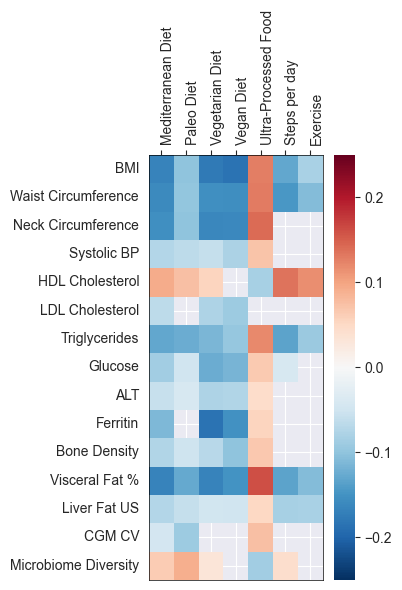

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import rankdata, norm
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings(action='ignore')
excl_col = ['Plate ID','QC Warning', 'RegistrationCode', 'StudyTypeID','StorageDT']
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pingouin import partial_corr 
import numpy as np
rename_scores={  'UPF_score': 'Ultra-Processed Food',
    'med_score_per_day': 'Mediterranean Diet',
    'paleo_score_per_day': 'Paleo Diet',
    'vegetarian_score_per_day': 'Vegetarian Diet',
    'vegan_score_per_day': 'Vegan Diet',
    'wfpb_score_per_day': 'WF Plant-Based Diet', 'steps':'Steps per day', 
               'sleep_efficiency_measured':'Sleep Efficiaency','exercise_score':'Exercise'}
def do_correl_pearson_numb_adj(ser1, ser2, covar):
        joined = pd.concat([ser1,ser2, covar], axis = 1).dropna()
        return  partial_corr(joined, ser1.name,ser2.name, list(covar.columns))[['r', 'p-val']].values[0]
    
    
def do_correl_pearson_numb(ser1, ser2):
        joined = pd.concat([ser1,ser2], axis = 1).dropna()
        return pearsonr(joined[ser1.name], joined[ser2.name])
    

def bonferroni_fdr_correction_by_column(pvalue_matrix):
    """

    """
    # Convert input to numpy array if it isn't already
    pvalue_matrix = np.array(pvalue_matrix)
    
    # Get the number of tests (rows) for each column
    n_tests = pvalue_matrix.shape[0]
    
    # Create output matrix of same shape
    corrected_matrix = np.zeros_like(pvalue_matrix)
    
    # Apply Bonferroni correction to each column
    for col in range(pvalue_matrix.shape[1]):
        # Multiply p-values by number of tests
        corrected_pvals = pvalue_matrix[:, col] * n_tests
        
        # Cap values at 1.0
        corrected_pvals = np.minimum(corrected_pvals, 1.0)
        
        # Store in output matrix
        corrected_matrix[:, col] = corrected_pvals
    
    return corrected_matrix
    
    
def do_corr_matrix_adj(A, B, title='',do_html=False, res=None, log_grouped_diff=None, without_fdr=False):
    #B phenotypes, A microbiome
    res_pval = pd.DataFrame()
    res_corr = pd.DataFrame()

    for col1 in A.columns:
        if col1=='gender' or col1=='age':
            continue
        for col2 in B.columns:
            if col1==col2 or col2=='age' or col1=='age':
                res_pval.loc[col1, col2] = do_correl_pearson_numb(A[col1], B[col2])[1]
                res_corr.loc[col1, col2] = do_correl_pearson_numb(A[col1], B[col2])[0]
            else:

                res_pval.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2],A[['age','gender']])[1]
                res_corr.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2],A[['age','gender']])[0]

    return res_corr, res_pval


phenotype_df=pd.read_csv('phenotype_matrix.csv', index_col=0)
lifestyle_df=pd.read_csv('lifestyle_matrix.csv', index_col=0)
# Define figure size (80 mm wide, adjusted height for the square figure)
fig, ax = plt.subplots(figsize=(4, 6))  


corr, pval=do_corr_matrix_adj(phenotype_df.dropna(subset=['age', 'gender']),lifestyle_df)



corrected_pval=pd.DataFrame(bonferroni_fdr_correction_by_column(pval), columns=pval.columns, index=pval.index)

signif_corr=corr[corrected_pval<0.05]

signif_corr=signif_corr.rename(columns=rename_scores,
                                        index  ={'bmi':'BMI', 'waist':'Waist Circumference', 'bt__hba1c':'HbA1C',
                            'bt__glucose': 'Glucose','sitting_blood_pressure_systolic':'Systolic BP',
                                                 'neck_circumference':'Neck Circumference',
                            'sitting_blood_pressure_diastolic':'BP Diastolic',
                            'bt__triglycerides':'Triglycerides',
                            'bt__hdl_cholesterol':'HDL Cholesterol','bt__ldl_cholesterol':'LDL Cholesterol',
                            'att_liver':'Liver Fat US', 'abi':'Ankle Brachial Index',
                            'dexa_t_score':'Bone Density',
                            'AHI':'Sleep Apnea (AHI)', 'bt__hemoglobin':'Hemoglobin',
                            'bt__wbc':'WBC','bt__ferritin':'Ferritin', 'bt__creatinine':'Creatinine',
                            'bt__alt_gpt':'ALT', 'bt__tsh':'TSH', 'bt__vitamin_b12':'Vitamin B12',
                                                 'cgm_mage': 'CGM MAGE', 'cgm_cv':"CGM CV", 
                                                'shannon_divercity':'Microbiome Diversity',
                                                'vat_fat_percent':'Visceral Fat %'})
# Create the heatmap
sns.heatmap(signif_corr.dropna(how='all').dropna(axis=1, how='all'), 
            ax=ax, cmap="RdBu_r", vmin=-0.25, vmax=0.25)

# Adjust tick positions and labels
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(rotation=90, ha='left')

# Add a frame around the heatmap
for spine in ax.spines.values():
    spine.set_visible(True)    # Make the spines visible
    spine.set_linewidth(0.5)   # Set the frame thickness (adjust as needed)
    spine.set_color('black')   # Set the frame color

# Tight layout to ensure everything fits properly
plt.tight_layout()

# Show the plot
plt.savefig('lifestyle_heatmap_revision.png', 
            dpi=300, bbox_inches='tight')


# Figure 5 B

In [ ]:
import ternary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'macronutrients.csv' is loaded in a similar manner
macronutrients = pd.read_csv('nutrients.csv', index_col=0) ###daily nutrients per person

# Calculate ratios
macronutrients['protein_ratio'] = macronutrients['protein_g'] * 4 / macronutrients['energy_kcal'] * 100
macronutrients['carb_ratio'] = macronutrients['carbohydrate_g'] * 4 / macronutrients['energy_kcal'] * 100
macronutrients['lipid_ratio'] = macronutrients['totallipid_g'] * 9 / macronutrients['energy_kcal'] * 100
macronutrients = macronutrients.reset_index()

# Color based on some condition
macronutrients['color'] = macronutrients['RegistrationCode'].apply(
    lambda x: 'lightcoral' if x in df[df['gender'] == 0].index else 'skyblue'
)

# Set ternary plot parameters
scale = 100
figure, tax = ternary.figure(scale=scale)

# Set the figure size to 70 mm by 70 mm
figure.set_size_inches(70 / 25.4, 70 / 25.4)  # Convert mm to inches

# Set global font properties for the plot
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 7

# Ternary plot formatting
tax.boundary(linewidth=1.0)
tax.gridlines(color="blue", multiple=10)
fontsize = 7
offset = 0.14

# Axis labels
tax.left_axis_label("% Fat", fontsize=fontsize, offset=offset)
tax.right_axis_label("% Carbohydrate", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("% Protein", fontsize=fontsize, offset=offset)

# Scatter plot for macronutrients
tax.scatter(macronutrients[['protein_ratio', 'carb_ratio', 'lipid_ratio']].values, 
            color=macronutrients['color'].values, alpha=0.8)

# Customize ticks and remove axis lines
tax.ticks(axis='lrb', multiple=20, linewidth=1, offset=0.025, tick_formats="%d", fontsize=fontsize)

# Remove axis lines
tax.get_axes().axis('off')

# Remove matplotlib ticks
tax.clear_matplotlib_ticks()

# Save figure
plt.savefig('10k_nutr_triangle.tiff', 
            dpi=300, format='tiff', bbox_inches='tight')
plt.savefig('10k_nutr_triangle.png', 
            dpi=300, bbox_inches='tight')

plt.show()

# Figure 5 D

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
# Sample data

fc=pd.read_csv('food_categories.csv', index_col=0) ###food categories 

fc_mean = fc.mean().sort_values(ascending=False).head(13)
fc_mean.loc['Other'] = 100 - fc_mean.sum()
cmap = plt.get_cmap('YlGnBu')
labels = fc_mean.index
colors_pie = cmap(np.linspace(0.2, 0.8, len(labels)))
colors_with_alpha = [to_rgba(color, alpha=0.8) for color in colors_pie]
# Set global font properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 6

# Convert 60 mm to inches (1 inch = 25.4 mm)
fig, ax = plt.subplots(figsize=(80/25.4, 70/25.4))

# Create the pie chart
ax.pie(fc_mean, labels=labels, autopct='%1.0f%%', startangle=-15, pctdistance=0.85, colors=colors_with_alpha)

# Adjust layout to make the plot tighter
plt.tight_layout()

# Show the plot (or you can save it if needed)

plt.savefig('10k_food_catergries.png', dpi=300, bbox_inches='tight')


In [12]:
!pip install lifelines


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 349.3/349.3 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 115.7/115.7 kB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 52.5/52.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=41308a6f9a15d2d7abe733eb05223256124dfca2d003efceb55a493a26c1ab29
  Stored in directory: c:\users\godnean\appdata\local\pip\cache\wheels\2c\c9\19\0e2ab6733f6527c1ee2daefc61822e187ff3814d4b1e239864
Successfully built autograd-gamma


# Figure 5 E

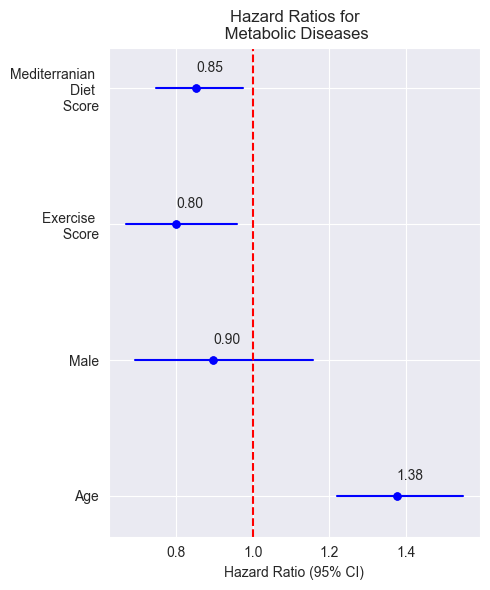

In [19]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Load your data
# Replace these with your actual file paths
#lifestyle_df = pd.read_csv('lifestyle_measurements.csv')
#outcome_df = pd.read_csv('health_outcome.csv')
import pandas as pd

# Example lifestyle_df


df=pd.read_csv('health_outputs_and_lifestyle.csv')
del df['Unnamed: 0']
cph = CoxPHFitter()

# Fit the model
# Fit the model
covariates = [col for col in df.columns if col not in ['RegistrationCode', 'time', 'event']]
# Fit the model
cph.fit(df, duration_col='time', event_col='event', formula=covariates)

# Get the hazard ratios and confidence intervals
hazard_ratios = cph.hazard_ratios_
conf_intervals = np.exp(cph.confidence_intervals_)

# Create a forest plot
plt.figure(figsize=(5, 6))

# Plot the hazard ratios and confidence intervals
for i, (var, hr) in enumerate(hazard_ratios.items()):
    plt.plot([hr, hr], [i, i], 'bo-', markersize=5)
    plt.plot([conf_intervals.loc[var, '95% lower-bound'], conf_intervals.loc[var, '95% upper-bound']], [i, i], 'b-')

# Customize the plot
plt.axvline(x=1, color='red', linestyle='--')
plt.yticks(range(len(hazard_ratios)), hazard_ratios.index)
plt.xlabel('Hazard Ratio (95% CI)')
plt.ylabel('')
plt.ylim(-0.3,3.3)
plt.title('Hazard Ratios for\n Metabolic Diseases')

# Add HR values to the plot
for i, hr in enumerate(hazard_ratios):
    plt.text(hr, i+0.15, f'{hr:.2f}', va='center', fontweight='normal')

plt.tight_layout()

plt.savefig('10k_hr.png', dpi=300, bbox_inches='tight')
